In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import timedelta
import simulate

In [2]:
spx = pd.read_csv('^GSPC.csv', index_col=0)

start = dt.date(2020, 1, 1)
end = dt.date(2050, 12, 31)


Market = simulate.Market(spx.iloc[-7500:, -2], start, end)

0.09297562032766947


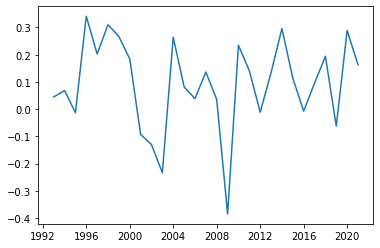

In [3]:
our_data = spx.iloc[-7500:, :]

our_data.index = pd.to_datetime(our_data.index)

in_years = our_data['Adj Close'].asfreq('BYS', 'pad')
plt.plot(in_years.pct_change())
print(in_years.pct_change().mean())

## Simulating a market

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

(array([  2.,   0.,   0.,   0.,   1.,   1.,   5.,  84., 262., 145.]),
 array([-1.50398660e-03, -1.29545564e-03, -1.08692468e-03, -8.78393715e-04,
        -6.69862753e-04, -4.61331791e-04, -2.52800829e-04, -4.42698666e-05,
         1.64261095e-04,  3.72792058e-04,  5.81323020e-04]),
 <BarContainer object of 10 artists>)

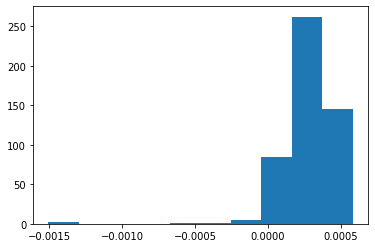

In [4]:
means = []
for i in range(500):
    print(i)
    market = Market.garch()
    market['Price'] = market['Price']*100/market['Price'].iloc[0]
    means.append(market['Price'].pct_change().mean())
    
    
# Annualizing returns

#market.index = market.index.year
print(means)

plt.hist(x=means)

In [5]:
actual = our_data['Adj Close'].pct_change().mean()
print(actual)
print(np.mean(means))

0.000374629702080118
0.0002859069343768067


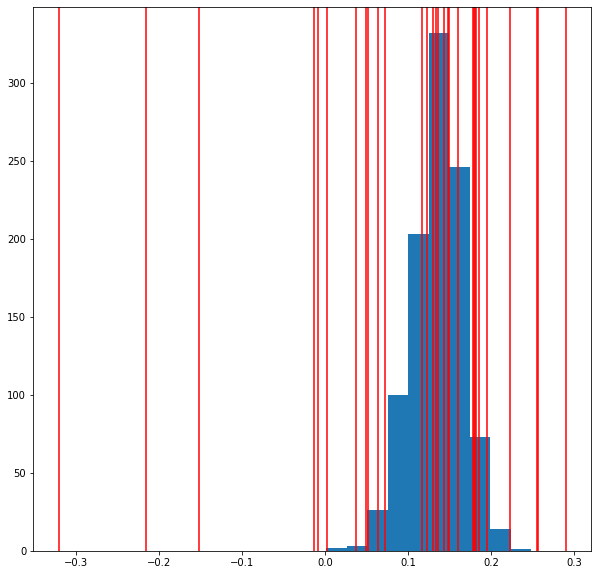

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.hist(x=means)
for i in range(len(market['Price'].pct_change())):
    ax.axvline(x=market['Price'].pct_change().iloc[i], color='r')

## Setting up functions to calculate performance

In [553]:
def nd(s, pv_u, dst, td, cash, phase, g):
    # determine new debt dependent on phase
	# dont aquire debt or repay debt in phase 3 or 4
    if phase == 3 or phase == 4:
        return 0, s
    
    if phase == 1:
        new_debt = min(max(g*s, g*(pv_u-td)), dst-pv_u-s)
        return (new_debt, s)
    
    if phase == 2: 
        stocks_sold = max(pv_u-dst, 0)
        print(stocks_sold)
        debt_repayment = min(td, s + stocks_sold)
        leftover_savings = max(s-debt_repayment - stocks_sold, 0)
        return -debt_repayment, leftover_savings

In [554]:
def update_cash(phase, pv_u, tv_u, s, cash, pi_rf, pi_hat):
    if phase <= 3:
        return 0, s
    
    if phase == 4:
        desired_cash = (pi_hat-pi_rf)*(tv_u+s)
        desired_savings = (pi_rf - pi_hat)*(tv_u+s)
        return desired_cash, desired_savings

In [555]:
def phase_check(phase, pi_rf, pi_rm, pi_hat, td):
    if phase == 4:
        return 4
    
    if td > 0:
        #has target not been reached?
        if pi_hat < pi_rm and phase <= 1:
            return 1
        else:
            # if target has been reached once and debt remains, stay in phase 2
            return 2
    
    #if target has been reached and no debt remains
    #is the value still above the target?
    if pi_hat < pi_rf:
        return 3
    else:
        return 4

In [517]:
def calc_pi(gamma, sigma, mr, rate, cost = 0):
    return (mr - cost - rate)/(gamma * sigma)

## Running checks on functions

## Combining with investment profile

In [564]:
savings = pd.read_csv('investment_plan.csv', sep=';', index_col=0)['Earnings'].values


In [565]:
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_rows', 100)

In [566]:
def calculate_return(savings, market_returns, gearing_cap, pi_rf, pi_rm, rf, rm):
    
    # Running controls
    assert len(savings) == len(market), 'Investment plan should be same no of periods as market' 
    
    # Setting up constants and dataframe for calculation
    ses = savings.sum()     # Possibly add more sophisticated discounting
    ist = pi_rm*ses
    columns = ['period', 'savings', 'cash', 'new_debt', 'total_debt', 'nip', 'pv_p', 
               'interest', 'market_returns', 'pv_u', 'tv_u', 'dst', 'phase', 'pi_hat', 'ses']
    
    print(ist)
    pp = pd.DataFrame(np.empty((len(savings), len(columns))), columns = columns)
    pp.is_copy = False 
    
    pp['ses'] = ses
    pp['period'] = range(len(savings))
    pp['market_returns'] = market_returns
    pp['savings'] = savings
    pp.loc[0, 'market_returns'] = 0
    
                      
    # Period 0 primo
    pp.loc[0, 'cash'] = 0
    pp.loc[0, 'new_debt'] = pp.loc[0, 'savings']*gearing_cap
    pp.loc[0, 'total_debt'] = pp.loc[0, 'new_debt']
    pp.loc[0, 'nip'] = pp.loc[0, 'new_debt'] + pp.loc[0, 'savings']
    pp.loc[0, 'pv_p'] = pp.loc[0, 'nip']
    pp.loc[0, 'pi_hat'] =  pp.loc[0, 'pv_p']/ses
    
    # Period 0 ultimo
    pp.loc[0, 'interest'] = pp.loc[0, 'new_debt']*rm
    #pp.loc[0, 'pv_u'] = pp.loc[0, 'pv_p']*(1+pp.loc[0, 'market_returns'])                      
    pp.loc[0, 'pv_u'] = pp.loc[0, 'pv_p']                 
    pp.loc[0, 'tv_u'] = pp.loc[0, 'pv_u'] + pp.loc[0, 'cash']
    pp.loc[0, 'dst'] = ist
    pp.loc[0, 'phase'] = 1
    
              
    
    # Looping over all reminaning periods
    for i in range(1, len(savings)):
 

        # Period t > 0 primo
        pp.loc[i, 'cash'] = pp.loc[i-1, 'cash']*(1+rf) 
        pp.loc[i, 'new_debt'], pp.loc[i, 'savings'] = nd(pp.loc[i, 'savings'], pp.loc[i-1, 'pv_u'], 
                                                         pp.loc[i-1, 'dst'], pp.loc[i-1, 'total_debt'],
                                                         pp.loc[i-1, 'cash'], pp.loc[i-1, 'phase'], gearing_cap)
        pp.loc[i, 'total_debt'] = pp.loc[i-1, 'total_debt'] + pp.loc[i, 'new_debt']
        
        pp.loc[i, 'cash'], pp.loc[i, 'savings'] = update_cash(pp.loc[i-1, 'phase'], pp.loc[i-1, 'pv_u'], pp.loc[i-1, 'tv_u'],
                                                                     pp.loc[i, 'savings'], pp.loc[i, 'cash'], pi_rf, pp.loc[i-1, 'pi_hat'])

        pp.loc[i, 'nip'] = pp.loc[i, 'savings'] + max(0, pp.loc[i, 'new_debt'])
        pp.loc[i, 'pv_p'] = pp.loc[i-1, 'pv_u'] + pp.loc[i, 'nip']
        
        
        
        
        # Period t > 0 ultimo
        pp.loc[i, 'interest'] = max(pp.loc[i, 'new_debt']*rm, 0)
        pp.loc[i, 'pv_u'] = pp.loc[i, 'pv_p']*(1+pp.loc[i, 'market_returns'])-pp.loc[i, 'interest']
        pp.loc[i, 'tv_u'] = pp.loc[i, 'pv_u'] + pp.loc[i, 'cash']
        pp.loc[i, 'pi_hat'] = min(pp.loc[i, 'pv_u']/ses, pp.loc[i, 'pv_u']/pp.loc[i, 'tv_u'])
        
        pp.loc[i, 'phase'] = phase_check(pp.loc[i-1, 'phase'], pi_rf, pi_rm, pp.loc[i, 'pi_hat'], pp.loc[i, 'total_debt'])
        target_pi = pi_rm if pp.loc[i-1, 'phase'] < 3 else pi_rf
        pp.loc[i, 'dst'] = max(pp.loc[i, 'tv_u']*target_pi, ist)  # Moving stock target

    return pp

In [567]:
investments = savings*0.05

rf = 0.02
rm = 0.03

gamma = 1.5
sigma = 0.20**2
mr = 0.07

pi_rf = calc_pi(gamma, sigma, mr, rf, cost = 0)
pi_rm = calc_pi(gamma, sigma, mr, rm, cost = 0)

print(pi_rf, pi_rm)


port = calculate_return(investments, market['Price'].pct_change().values, 1, pi_rf, pi_rm, rf, rm)

0.8333333333333333 0.6666666666666666
3193289.1999999997
1226790.3496585642
0
0
0
347749.34007004555
196709.17871761136


In [568]:
port

,period,savings,cash,new_debt,total_debt,nip,pv_p,interest,market_returns,pv_u,tv_u,dst,phase,pi_hat,ses
0,0,"20,000.00",0.00,"20,000.00","20,000.00","40,000.00","40,000.00",600.00,0.00,"40,000.00","40,000.00","3,193,289.20",1.00,0.01,"4,789,933.80"
1,1,"21,000.00",0.00,"21,000.00","41,000.00","42,000.00","82,000.00",630.00,0.04,"84,717.57","84,717.57","3,193,289.20",1.00,0.02,"4,789,933.80"
2,2,"22,050.00",0.00,"43,717.57","84,717.57","65,767.57","150,485.13","1,311.53",0.06,"158,006.32","158,006.32","3,193,289.20",1.00,0.03,"4,789,933.80"
3,3,"23,152.60",0.00,"73,288.75","158,006.32","96,441.35","254,447.67","2,198.66",0.40,"354,338.78","354,338.78","3,193,289.20",1.00,0.07,"4,789,933.80"
4,4,"24,310.20",0.00,"196,332.47","354,338.78","220,642.67","574,981.45","5,889.97",0.24,"705,289.08","705,289.08","3,193,289.20",1.00,0.15,"4,789,933.80"
5,5,"25,525.60",0.00,"350,950.30","705,289.08","376,475.90","1,081,764.99","10,528.51",0.04,"1,114,756.77","1,114,756.77","3,193,289.20",1.00,0.23,"4,789,933.80"
6,6,"26,802.00",0.00,"409,467.69","1,114,756.77","436,269.69","1,551,026.46","12,284.03",0.52,"2,346,338.78","2,346,338.78","3,193,289.20",1.00,0.49,"4,789,933.80"
7,7,"28,142.00",0.00,"818,808.42","1,933,565.20","846,950.42","3,193,289.20","24,564.25",0.39,"4,420,079.55","4,420,079.55","3,193,289.20",2.00,0.92,"4,789,933.80"
8,8,0.00,0.00,"-1,256,339.55","677,225.65",0.00,"4,420,079.55",0.00,-0.47,"2,330,565.24","2,330,565.24","3,193,289.20",2.00,0.49,"4,789,933.80"
9,9,0.00,0.00,"-31,026.60","646,199.05",0.00,"2,330,565.24",0.00,0.21,"2,831,285.31","2,831,285.31","3,193,289.20",2.00,0.59,"4,789,933.80"


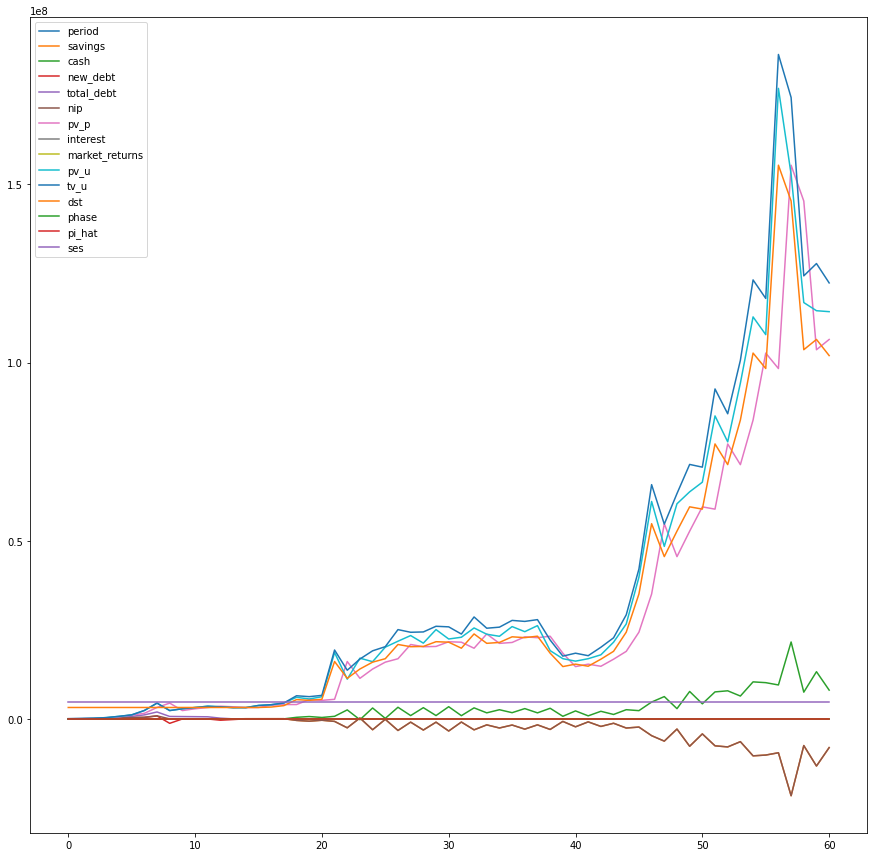

In [569]:
fig, ax = plt.subplots(1, 1, figsize = (15, 15))
columns = ['period', 'savings', 'cash', 'new_debt', 'total_debt', 'nip', 'pv_p', 
               'interest', 'market_returns', 'pv_u', 'tv_u', 'dst', 'phase', 'pi_hat', 'ses']
ax.plot(port)
ax.legend(columns)

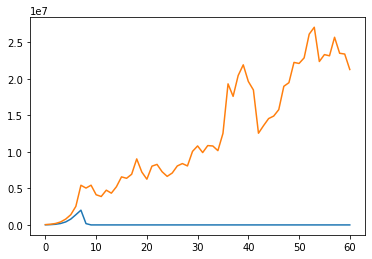

In [562]:
plt.plot(port.loc[:,['total_debt', 'tv_u']])